<a href="https://colab.research.google.com/github/simeonwetzel/agile2025-llm-geo-search/blob/main/2_LLM_Calls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Topics

* LLM calls
* Query interpretation
* RAG
  * Retrieval
  * Generation
* Conversation


Queries building by attribute (name):

        "Tell me about the Zwinger Palace in Dresden",
        "Zwinger",
        "Semperoper",
        "Frauenkirche",
        "Where is the Frauenkirche located?",
        "Show me information on the Semperoper",
        "I want to find the Dresden Castle",
        "What can you tell me about the Military History Museum?",
        "Give me details on the Green Vault",
        "Find the Blue Wonder bridge",
        "Show me the Hygiene Museum",
        "Tell me about the Yenidze building",
        "Locate the Albertinum in Dresden"

Queries building by type:

        "List all museums in Dresden",
        "Find the hospitals in Dresden",
        "Show me art galleries in Dresden",
        "Are there any public libraries in Dresden?",
        "What schools are there in Dresden?",
        "Search for historical buildings in Dresden",
        "Look up churches in Dresden",
        "Which theaters are in Dresden?",
        "What kind of tourist attractions are in Dresden?",
        "Find universities in Dresden"

Advanced queries:

        "Restaurants in Dresden Neustadt" # (poly/poly => intersection, point/poly => contains)
        "Historic buildings in a 2km radius around the Semperoper" # Requires a tool for buffered search
        "Restaurants on the main street"
        "Buildings with a size greater than 100 square meters"

# Part 1: Simple LLM Call

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
!pip install -qU langchain-openai

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
# system message => how the bot should interpret the conversation/how it should behave when it sees users' inputs
# user message => user's inputs
messages = [
    (
        "system",
        "You are a helpful assistant that returns names of places in a given sentence, along with the number of place names.", #
    ),
    ("human", "is the capital city of the German state of Saxony and its second most populous city after Leipzig."),
]
messages

In [ ]:
ai_msg = llm.invoke(messages)
ai_msg

In [ ]:
print(ai_msg.content)

# Part 2: Query interpretation/Geocoding

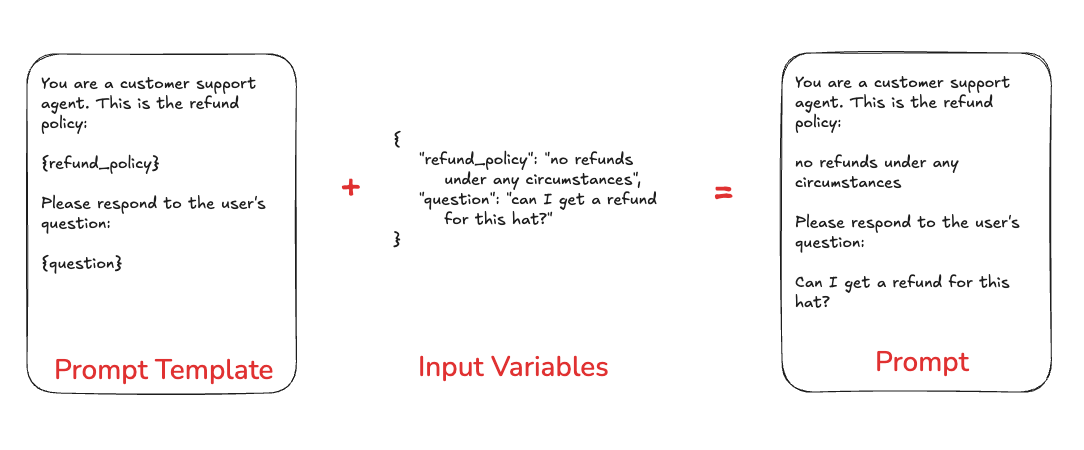
Picture source: https://docs.smith.langchain.com/prompt_engineering/concepts

Geocoding through prompt template

In [ ]:
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

from langchain_openai import ChatOpenAI
from langchain import PromptTemplate

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

LocationExtraction_template = """
You are a virtual assistant that extracts entities from the provided text.
USER: Text: {input_text}
ASSISTANT: I’ve read the text.
USER: What are all {entity_type} mentioned in the text?
ASSISTANT: Return the model's prediction as geojson. For every {entity_type} found, mention also the coordinates in decimal degrees.
"""
#Alternative: Return the model's prediction as geojson. For every {entity_type} found, mention also the coordinates in decimal degrees. The geojson should start with square brackets

# prompt template => generate system messages dynamically
prompt_template = PromptTemplate(
    input_variables=["input_text", "entity_type"],
    template=LocationExtraction_template
)

chain = prompt_template | llm

example_text = """
Dresden is the capital city of the German state of Saxony and its second most populous city after Leipzig. It is the 12th most populous city of Germany,
the fourth largest by area (after Berlin, Hamburg, and Cologne), and the third-most populous city in the area of former East Germany, after Berlin and Leipzig.
Dresden's urban area comprises the towns of Freital, Pirna, Radebeul, Meissen, Coswig, Radeberg, and Heidenau and has around 790,000 inhabitants.
The Dresden metropolitan area has approximately 1.34 million inhabitants.
Dresden is the second largest city on the River Elbe after Hamburg.
"""

chain.invoke({"input_text": example_text,  "entity_type": "state"}).content # Alternative: place, location, locations, place names, river, state

Geocoding through LLMs with structured output

In [ ]:
import os

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

from langchain_openai import ChatOpenAI
from langchain import PromptTemplate

llm_w_so = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_structured_output(method="json_mode")

LocationExtraction_template = """
You are a virtual assistant that extracts entities from the provided text.
USER: Text: {input_text}
ASSISTANT: I’ve read the text.
USER: What are all {entity_type} mentioned in the text?
ASSISTANT: Return the model's prediction formatted as geojson. For every {entity_type} found, mention also the coordinates in decimal degrees.
"""

prompt_template = PromptTemplate(
    input_variables=["input_text", "entity_type"],
    template=LocationExtraction_template
)

chain = prompt_template | llm_w_so

example_text = """
Dresden is the capital city of the German state of Saxony and its second most populous city after Leipzig. It is the 12th most populous city of Germany,
the fourth largest by area (after Berlin, Hamburg, and Cologne), and the third-most populous city in the area of former East Germany, after Berlin and Leipzig.
Dresden's urban area comprises the towns of Freital, Pirna, Radebeul, Meissen, Coswig, Radeberg, and Heidenau and has around 790,000 inhabitants.
The Dresden metropolitan area has approximately 1.34 million inhabitants.
Dresden is the second largest city on the River Elbe after Hamburg.
"""

chain.invoke({"input_text": example_text,  "entity_type": "place name"}) # Alternative: place, location, locations, place names

In [ ]:
query = "German Hygiene Museum and Semperoper" # Semperoper, Deutsches Hygiene Museum, German Hygiene Museum

places = chain.invoke({"input_text": query,  "entity_type": "place name"}) # Alternative: place, location, locations, place names
places

In [ ]:
import folium

popup = folium.GeoJsonPopup(fields=["name"])

m = folium.Map([51.05, 13.73], zoom_start=14)

folium.GeoJson(places, popup=popup).add_to(m)

m

Next step: Compute the Q-Footprint from the P-Footprints

# Part 3: Retrieval

In [ ]:
!pip -q install chromadb langchain-chroma langchain-openai

In [ ]:
import chromadb
chroma_client = chromadb.HttpClient(host='https://klimakonform-maps.geo.tu-dresden.de/chromadb')
chroma_client.heartbeat()

In [ ]:
!pip install -qU langchain-huggingface

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings_hf = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store_building_with_names = Chroma(
    client=chroma_client,
    collection_name="buildings_with_names",
    embedding_function=embeddings_hf,
    create_collection_if_not_exists=False
)

vector_store_buildings_grouped_by_type = Chroma(
    client=chroma_client,
    collection_name="buildings_grouped_by_type",
    #embedding_function=embeddings_hf,
    create_collection_if_not_exists=False
)

## Response

In [ ]:
# https://python.langchain.com/docs/integrations/vectorstores/chroma/
response = vector_store_building_with_names.similarity_search("Show me the Hygiene Museum")
response

In [ ]:
document = response[0]
document

In [ ]:
document.id

In [ ]:
document.metadata

In [ ]:
import json

def create_geojson_feature(response, rank):
    feature = json.loads(response['geometry'])
    geojson = {
        "type": "Feature",
        "properties": feature['properties'],
        "geometry": { "type": "Polygon", "coordinates": feature['coordinates']}
    }
    geojson["properties"]['rank'] = rank
    print(geojson["properties"]['name'], "- rank:", rank)
    return geojson

features = []

for i, document in enumerate(response):
   feature = create_geojson_feature(document.metadata, i+1)
   features.append(feature)


results = {
    "type": "FeatureCollection",
    "features": features
}

In [ ]:
import folium

popup = folium.GeoJsonPopup(fields=["name", "rank"])

m = folium.Map([51.05, 13.73], zoom_start=14)

folium.GeoJson(results, popup=popup).add_to(m)

m

## Response with score

In [ ]:
response_with_score = vector_store_building_with_names.similarity_search_with_score("Semperoper")
response_with_score

In [ ]:
import json

def create_geojson_feature(response, rank, score):
    feature = json.loads(response['geometry'])
    geojson = {
        "type": "Feature",
        "properties": feature['properties'],
        "geometry": { "type": "Polygon", "coordinates": feature['coordinates']}
    }
    geojson["properties"]['rank'] = rank
    geojson["properties"]['score'] = score
    print(geojson["properties"]['name'], "; rank:", rank, "; score:", score)
    return geojson

features = []

for i, item in enumerate(response_with_score):
   document, score  = item
   feature = create_geojson_feature(document.metadata, i+1, score)
   features.append(feature)


results = {
    "type": "FeatureCollection",
    "features": features
}

## Response using MMR

MMR (Maximum Margin Relevance): select search targets that are relevant to a query **and** diverse among each other

In [ ]:
#https://api.python.langchain.com/en/latest/vectorstores/langchain_core.vectorstores.VectorStore.html#langchain_core.vectorstores.VectorStore.max_marginal_relevance_search
response_with_mmr = vector_store_building_with_names.max_marginal_relevance_search("Semperoper")
response_with_mmr

In [ ]:
import json

def create_geojson_feature(response, rank):
    feature = json.loads(response['geometry'])
    geojson = {
        "type": "Feature",
        "properties": feature['properties'],
        "geometry": { "type": "Polygon", "coordinates": feature['coordinates']}
    }
    geojson["properties"]['rank'] = rank
    print(geojson["properties"]['name'], "- rank:", rank)
    return geojson

features = []

for i, document in enumerate(response_with_mmr):
   feature = create_geojson_feature(document.metadata, i+1)
   features.append(feature)


results = {
    "type": "FeatureCollection",
    "features": features
}

In [ ]:
import folium

popup = folium.GeoJsonPopup(fields=["name", "rank"])

m = folium.Map([51.05, 13.73], zoom_start=14)

folium.GeoJson(results, popup=popup).add_to(m)

m

# Part 4: Generation

In [ ]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
prompt

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm

In [ ]:
chain = prompt | llm
chain

In [ ]:
query = "Show me the Hygiene Museum"

docs = response

chain.invoke({"context": docs, "question": query})

RAG formatted

In [ ]:
chain.invoke({"context": docs, "question": query}).content

Without RAG - as a baseline

In [ ]:
llm.invoke(query).content

# Part 5: Conversation

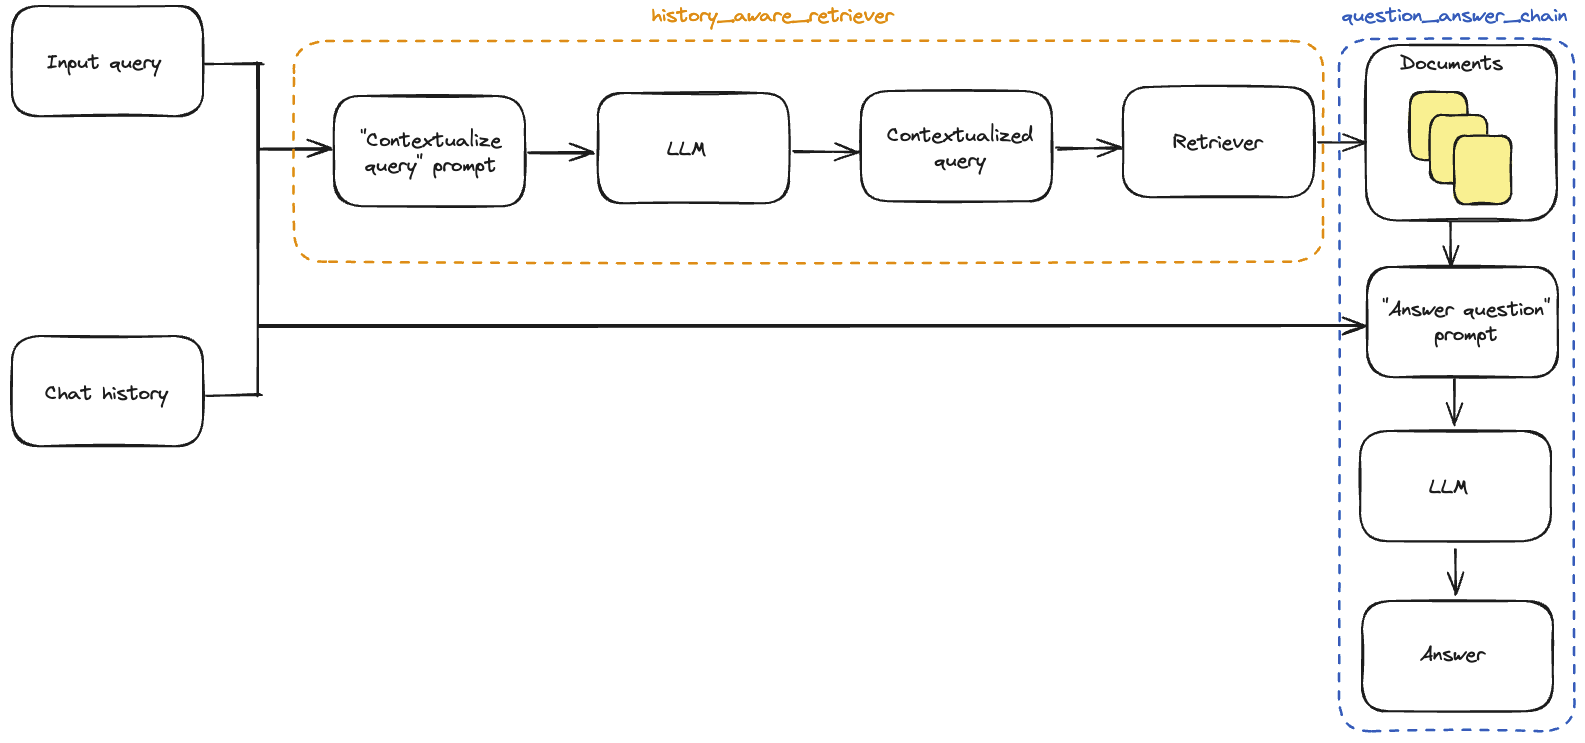
Picture source: https://python.langchain.com/v0.2/docs/how_to/qa_chat_history_how_to/

Basic history-aware prompt

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder # https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.chat.MessagesPlaceholder.html

system_prompt = (
    "You are a helpful assistant"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

In [ ]:
prompt.messages

In [ ]:
prompt.invoke({
       "chat_history": [("human", "what is 1 + 1"), ("ai", "1 + 1 is 2")],
       "input": "now multiply that by 4"})

Retriever: interface to query documents from the vector store

In [ ]:
!pip -q install chromadb langchain-chroma langchain_community

In [ ]:
import chromadb
chroma_client = chromadb.HttpClient(host='https://klimakonform-maps.geo.tu-dresden.de/chromadb')
chroma_client.heartbeat()

In [ ]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vector_store_building_with_names = Chroma(
    client=chroma_client,
    collection_name="buildings_with_names",
    embedding_function=embeddings_hf,
    create_collection_if_not_exists=False

)

vector_store_buildings_grouped_by_type = Chroma(
    client=chroma_client,
    collection_name="buildings_grouped_by_type",
    embedding_function=embeddings_hf,
    create_collection_if_not_exists=False

)

retriever = vector_store_building_with_names.as_retriever()

History-aware retriever

In [ ]:
### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# a history-aware retriever consists of a llm, a retriever and a prompt to contextualize the query
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt)

In [ ]:
history_aware_retriever

In [ ]:
history_aware_retriever.invoke({"input": "What is the semperoper", "chat_history": []})

In [ ]:
# https://python.langchain.com/v0.2/docs/how_to/qa_chat_history_how_to/

from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_chroma import Chroma
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder # Message PlaceHolder is useful to create dynamic messages
from langchain_core.runnables.history import RunnableWithMessageHistory

retriever = vector_store_building_with_names.as_retriever()

### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt)

### Answer question ###
system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
store = {}

def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]

conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [ ]:
conversational_rag_chain.invoke(
    {"input": "What is the Semperoper?"},
    config={
        "configurable": {"session_id": "123abc"}  # constructs a key "123abc" in `store`.
    },
)["answer"]

In [ ]:
conversational_rag_chain.invoke(
    {"input": "Where is it located?"},
    config={"configurable": {"session_id": "123abc"}},
)["answer"]

In [ ]:
conversational_rag_chain.invoke(
    {"input": "How far is it from the German Hygiene Museum?"},
    config={"configurable": {"session_id": "123abc"}},
)["answer"]

In [ ]:
conversational_rag_chain.invoke(
    {"input": "What is its capacity?"},
    config={"configurable": {"session_id": "123abc"}},
)["chat_history"]

In [ ]:
get_session_history("123abc").messages

# Outlook

Not covered, but probably useful: [Ensemble Retrievers](https://python.langchain.com/docs/how_to/ensemble_retriever/)



